## Initial Setup

In [37]:
import os
DATASET_PATH = "/kaggle/input/animals10/raw-img"


In [38]:
import os
anim= os.listdir(DATASET_PATH)
print(anim)

['cavallo', 'pecora', 'elefante', 'gatto', 'scoiattolo', 'gallina', 'ragno', 'mucca', 'cane', 'farfalla']


In [39]:
total=0
for x in anim:
    dir = os.path.join(DATASET_PATH, x)
    y = len(os.listdir(dir))
    print(x+':', y)
    total = total + y
print('\nTotal :', total)


cavallo: 2623
pecora: 1820
elefante: 1446
gatto: 1668
scoiattolo: 1862
gallina: 3098
ragno: 4821
mucca: 1866
cane: 4863
farfalla: 2112

Total : 26179


## Data Preparation

In [40]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(DATASET_PATH,
                                                    batch_size=128,
                                                    shuffle = True,
                                                    class_mode='categorical',
                                                    color_mode="rgb",
                                                    subset="training",
                                                    target_size=(224, 224))

validation_generator  = train_datagen.flow_from_directory(DATASET_PATH,
                                                    batch_size=128,
                                                    shuffle = True,
                                                    class_mode='categorical',
                                                    color_mode="rgb",
                                                    subset="validation",
                                                    target_size=(224, 224))


Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [41]:
# Custom callbacks for neural network training
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 90%!")

def generate_custom_callbacks(saved_model_path: str = "custom_checkpoints/best_model.hdf5"):
    # Define personalized training callbacks
    custom_callbacks = [
        # Stop training early if there's an increase in validation loss
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),

        # Adjust learning rate dynamically if validation loss increases
        ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6),

        # Save the best model weights during training
        ModelCheckpoint(
            filepath=saved_model_path,
            save_weights_only=True,
            monitor="val_accuracy",
            mode="max",
            save_best_only=True
        ),
        myCallback()
    ]
    return custom_callbacks


In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization


model = Sequential([

        # Convolution Layer (Feature Extraction)
        Conv2D(64, (3,3), activation="relu", input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),

        Conv2D(64, (3,3), activation="relu"),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation="relu"),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation="relu"),
        MaxPooling2D(2,2),

        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(0.2),

        # Classifier Layer
        Flatten(),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(10, activation="softmax")

    ])

## Modeling

In [43]:
model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 111, 111, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 26, 26, 128)      

## Model Builder

In [44]:

cb = generate_custom_callbacks("custom_checkpoints/best_model.hdf5")

h = model.fit(
    train_generator,
    validation_data=validation_generator,
    callbacks=cb,
    epochs=60,
    verbose=1
)


Epoch 1/60
164/164 [==============================] - 277s 2s/step - loss: 1.9629 - accuracy: 0.3182 - val_loss: 2.7287 - val_accuracy: 0.2156 - lr: 0.0010
Epoch 2/60
164/164 [==============================] - 93s 568ms/step - loss: 1.6432 - accuracy: 0.4215 - val_loss: 1.9930 - val_accuracy: 0.2972 - lr: 0.0010
Epoch 3/60
164/164 [==============================] - 94s 570ms/step - loss: 1.4355 - accuracy: 0.5037 - val_loss: 1.5350 - val_accuracy: 0.4627 - lr: 0.0010
Epoch 4/60
164/164 [==============================] - 94s 570ms/step - loss: 1.2376 - accuracy: 0.5721 - val_loss: 1.4427 - val_accuracy: 0.4822 - lr: 0.0010
Epoch 5/60
164/164 [==============================] - 92s 561ms/step - loss: 1.1270 - accuracy: 0.6096 - val_loss: 1.2018 - val_accuracy: 0.5847 - lr: 0.0010
Epoch 6/60
164/164 [==============================] - 92s 558ms/step - loss: 1.0297 - accuracy: 0.6467 - val_loss: 1.7175 - val_accuracy: 0.4499 - lr: 0.0010
Epoch 7/60
164/164 [==============================] - 

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape

# Define the model
mv = Sequential([
    # Pre-trained MobileNetV3Small layer
    tf.keras.applications.MobileNetV3Small(weights="imagenet", include_top=False, pooling="max", input_shape=(150, 150, 3)),
    # Flatten the output
    Flatten(),
    # Reshape to the desired shape
    Reshape((6, 6, 16)),  # Adjust the shape based on the output shape of MobileNetV3Small
    
    # Additional Conv2D and MaxPooling2D layers
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    # Flatten layer
    Flatten(),
    
    # Classifier Layers
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    
    # Output layer
    Dense(10, activation="softmax")
])

# Freeze the weights of the pre-trained MobileNetV3Small layer
mv.layers[0].trainable = False

# Display the model summary
mv.summary()


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 576)               939120    
 al)                                                             
                                                                 
 flatten_21 (Flatten)        (None, 576)               0         
                                                                 
 reshape_5 (Reshape)         (None, 6, 6, 16)          0         
                                                                 
 conv2d_53 (Conv2D)          (None, 6, 6, 128)         18560     
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 3, 3, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (None, 3, 3, 256)       

In [75]:
mv.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
mv.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 576)               939120    
 al)                                                             
                                                                 
 flatten_21 (Flatten)        (None, 576)               0         
                                                                 
 reshape_5 (Reshape)         (None, 6, 6, 16)          0         
                                                                 
 conv2d_53 (Conv2D)          (None, 6, 6, 128)         18560     
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 3, 3, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (None, 3, 3, 256)       

In [78]:
# training model
rs = generate_custom_callbacks("custom_checkpoints/mv4.hdf5")

MobileNetV3SmallTransfer = mv.fit(
    train_generator,
    validation_data=validation_generator,
    callbacks=rs,
    epochs=50,
    verbose=1
)


Epoch 1/50
164/164 [==============================] - 91s 554ms/step - loss: 0.0360 - accuracy: 0.9928 - val_loss: 0.3049 - val_accuracy: 0.9176 - lr: 4.0000e-05
Epoch 2/50
164/164 [==============================] - 90s 547ms/step - loss: 0.0314 - accuracy: 0.9943 - val_loss: 0.3119 - val_accuracy: 0.9197 - lr: 4.0000e-05
Epoch 3/50
164/164 [==============================] - 91s 554ms/step - loss: 0.0275 - accuracy: 0.9952 - val_loss: 0.3205 - val_accuracy: 0.9170 - lr: 4.0000e-05
Epoch 4/50
164/164 [==============================] - 91s 552ms/step - loss: 0.0247 - accuracy: 0.9962 - val_loss: 0.3206 - val_accuracy: 0.9180 - lr: 4.0000e-05
Epoch 5/50
164/164 [==============================] - 91s 553ms/step - loss: 0.0210 - accuracy: 0.9972 - val_loss: 0.3249 - val_accuracy: 0.9192 - lr: 8.0000e-06
Epoch 6/50
164/164 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9975
The accuracy of the training set and the validation set has reached > 90%!
164/164 [==========

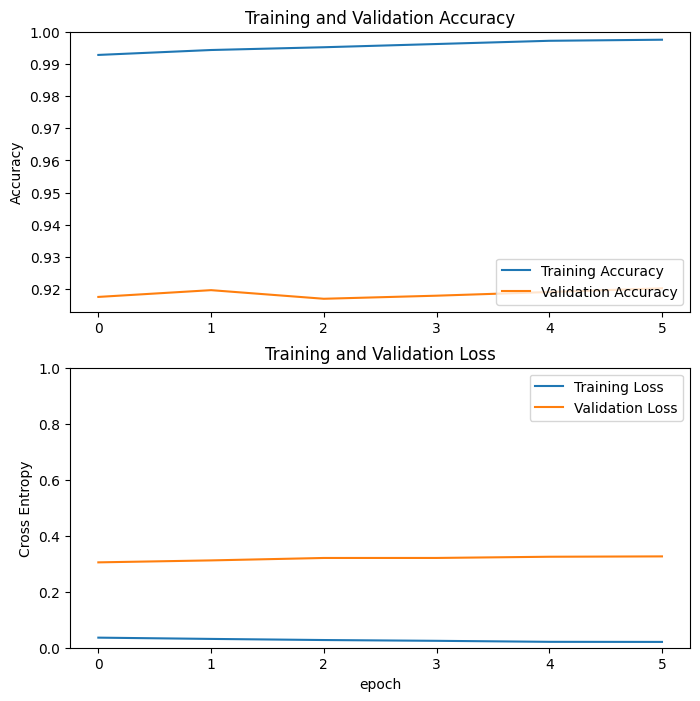

In [79]:
acc = MobileNetV3SmallTransfer.history['accuracy']
val_acc = MobileNetV3SmallTransfer.history['val_accuracy']

loss = MobileNetV3SmallTransfer.history['loss']
val_loss = MobileNetV3SmallTransfer.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [80]:

converter = tf.lite.TFLiteConverter.from_keras_model(mv)
tflite_model = converter.convert()

In [81]:
import pathlib

tflite_model_file = pathlib.Path('animals.tflite')
tflite_model_file.write_bytes(tflite_model)


5550456